# Building Weather forecasting model

# Prepare Data

# Import the necessary packages

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline




In [2]:
# data wrangling function
def wrangle(filepath):
    # read csv file
    df = pd.read_csv(filepath,parse_dates=['last_updated'], index_col='last_updated')
    # drop unesuful features for weather forecasting with linear regression model
    df.drop(columns= ["country","location_name","latitude","longitude","timezone","last_updated_epoch",
                      "temperature_fahrenheit","feels_like_celsius","feels_like_fahrenheit","uv_index",
                      "gust_mph","gust_kph","air_quality_Carbon_Monoxide","air_quality_Ozone","air_quality_Nitrogen_dioxide",
                      "air_quality_Sulphur_dioxide","air_quality_PM2.5","air_quality_PM10","air_quality_us-epa-index",
                      "air_quality_gb-defra-index","moonrise","moonset","moon_illumination","pressure_in","visibility_miles",
                      "precip_in","wind_mph","moon_phase"],
            inplace= True)
    # remove outliers
    df = df[df["temperature_celsius"]>0]
    #drop columns with multicollinearity 
    df.drop(columns= ["precip_mm","humidity"], inplace = True)
    # resample data
    df = df["temperature_celsius"].resample("D").mean().fillna(method="ffill").to_frame()
    # sort df
    df = df.sort_index()
    # Add lag feature
    df["T.L1"] = df["temperature_celsius"].shift(1)
    #drop NaN values
    df.dropna(inplace=True)
    
    
        
    return df
    
    

In [3]:
df = wrangle("/kaggle/input/weather-repository/GlobalWeatherRepository.csv")

/tmp/ipykernel_36/3288730549.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df["temperature_celsius"].resample("D").mean().fillna(method="ffill").to_frame()


In [4]:
#output the columns
df.head()

,temperature_celsius,T.L1
last_updated,,
2024-05-17,24.451648,23.767196
2024-05-18,25.355610,24.451648
2024-05-19,25.270103,25.355610
2024-05-20,25.567010,25.270103
2024-05-21,25.383077,25.567010


In [9]:
# print df shape
print("df shape:", df.shape)
# print df info
print(df.info())


df shape: (24247, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24247 entries, 2024-05-16 13:15:00 to 2024-09-18 12:45:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_celsius  24247 non-null  float64
 1   condition_text       24247 non-null  object 
 2   wind_kph             24247 non-null  float64
 3   wind_degree          24247 non-null  int64  
 4   wind_direction       24247 non-null  object 
 5   pressure_mb          24247 non-null  float64
 6   cloud                24247 non-null  int64  
 7   visibility_km        24247 non-null  float64
 8   sunrise              24247 non-null  object 
 9   sunset               24247 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.0+ MB
None


In [5]:
# check for null values
df.isnull().any()

temperature_celsius    False
T.L1                   False
dtype: bool

In [14]:
# used describe to check outliers
descr= df.describe()
descr

,temperature_celsius,wind_kph,wind_degree,pressure_mb,cloud,visibility_km
count,24247.000000,24247.000000,24247.000000,24247.000000,24247.000000,24247.000000
mean,26.337349,14.143432,177.835526,1012.150905,38.420506,9.766462
std,7.035813,20.877223,100.877627,6.205594,32.690074,2.264963
min,-3.700000,3.600000,1.000000,978.000000,0.000000,0.000000
25%,22.900000,6.800000,94.000000,1009.000000,4.000000,10.000000
50%,27.100000,13.000000,179.000000,1012.000000,25.000000,10.000000
75%,30.200000,19.100000,260.000000,1016.000000,75.000000,10.000000
max,49.200000,2963.200000,360.000000,1045.000000,100.000000,24.000000


# Explore

<Axes: title={'center': 'Distribution of temperature Readings'}>

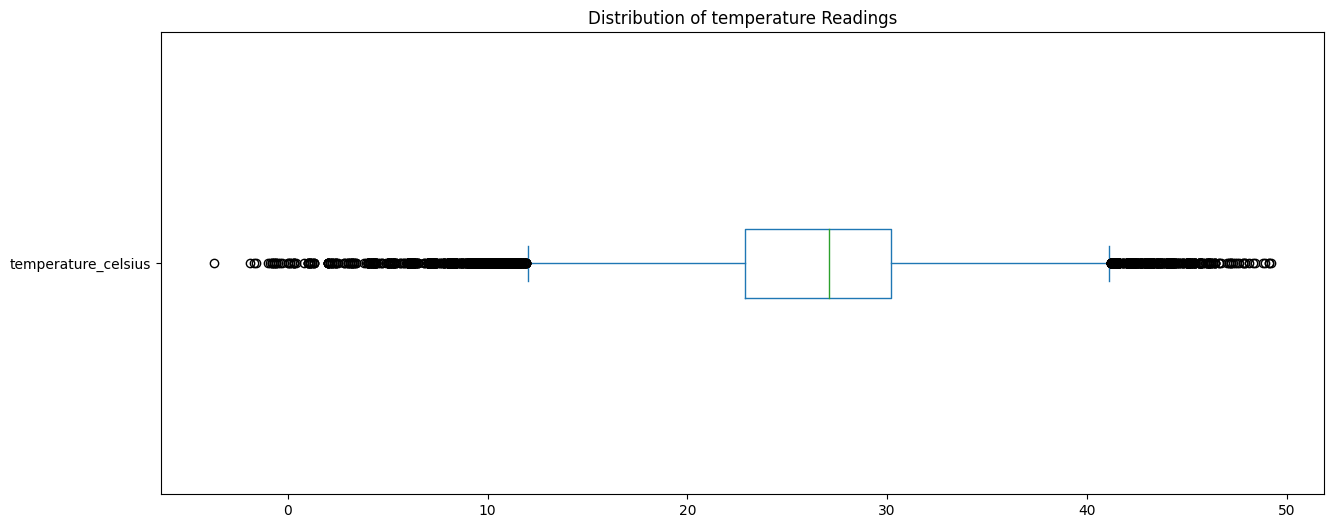

In [6]:
# plot a boxplot to identify ouliers
fig, ax = plt.subplots(figsize=(15, 6));
df["temperature_celsius"].plot(kind="box",vert=False,title="Distribution of temperature Readings", ax=ax)

<Axes: title={'center': 'temperature Time Series'}, xlabel='Time', ylabel='temperature_celsius'>

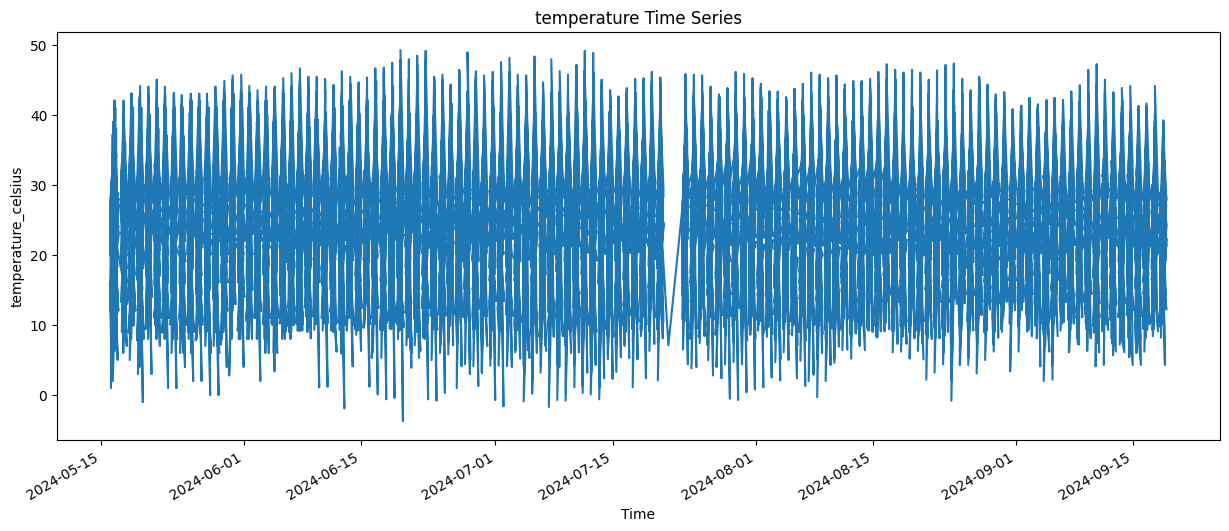

In [7]:
# plot a subplot to identify missing values
fig, ax = plt.subplots(figsize=(15, 6))
df["temperature_celsius"].plot(xlabel="Time",ylabel="temperature_celsius",title="temperature Time Series", ax =ax)

Text(0.5, 1.0, 'temperature_celsius Autocorrelation')

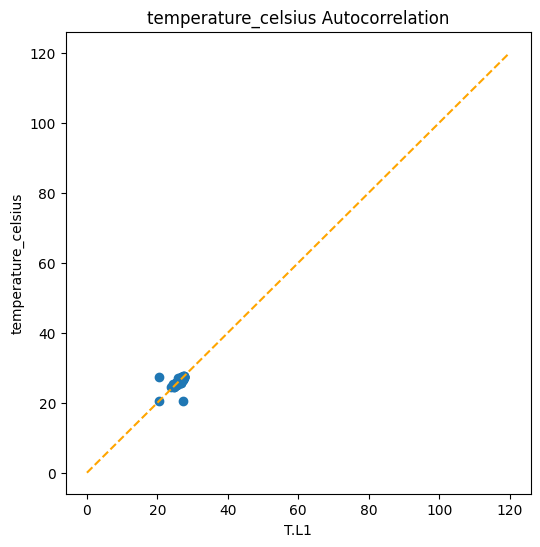

In [6]:
#Autocorrelation plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["T.L1"], y=df["temperature_celsius"])
ax.plot([0,120],[0,120],linestyle="--",color="orange")
plt.xlabel("T.L1")
plt.ylabel("temperature_celsius")
plt.title("temperature_celsius Autocorrelation")

array([[<Axes: title={'center': 'temperature_celsius'}>,
        <Axes: title={'center': 'wind_kph'}>],
       [<Axes: title={'center': 'wind_degree'}>,
        <Axes: title={'center': 'pressure_mb'}>],
       [<Axes: title={'center': 'cloud'}>,
        <Axes: title={'center': 'visibility_km'}>]], dtype=object)

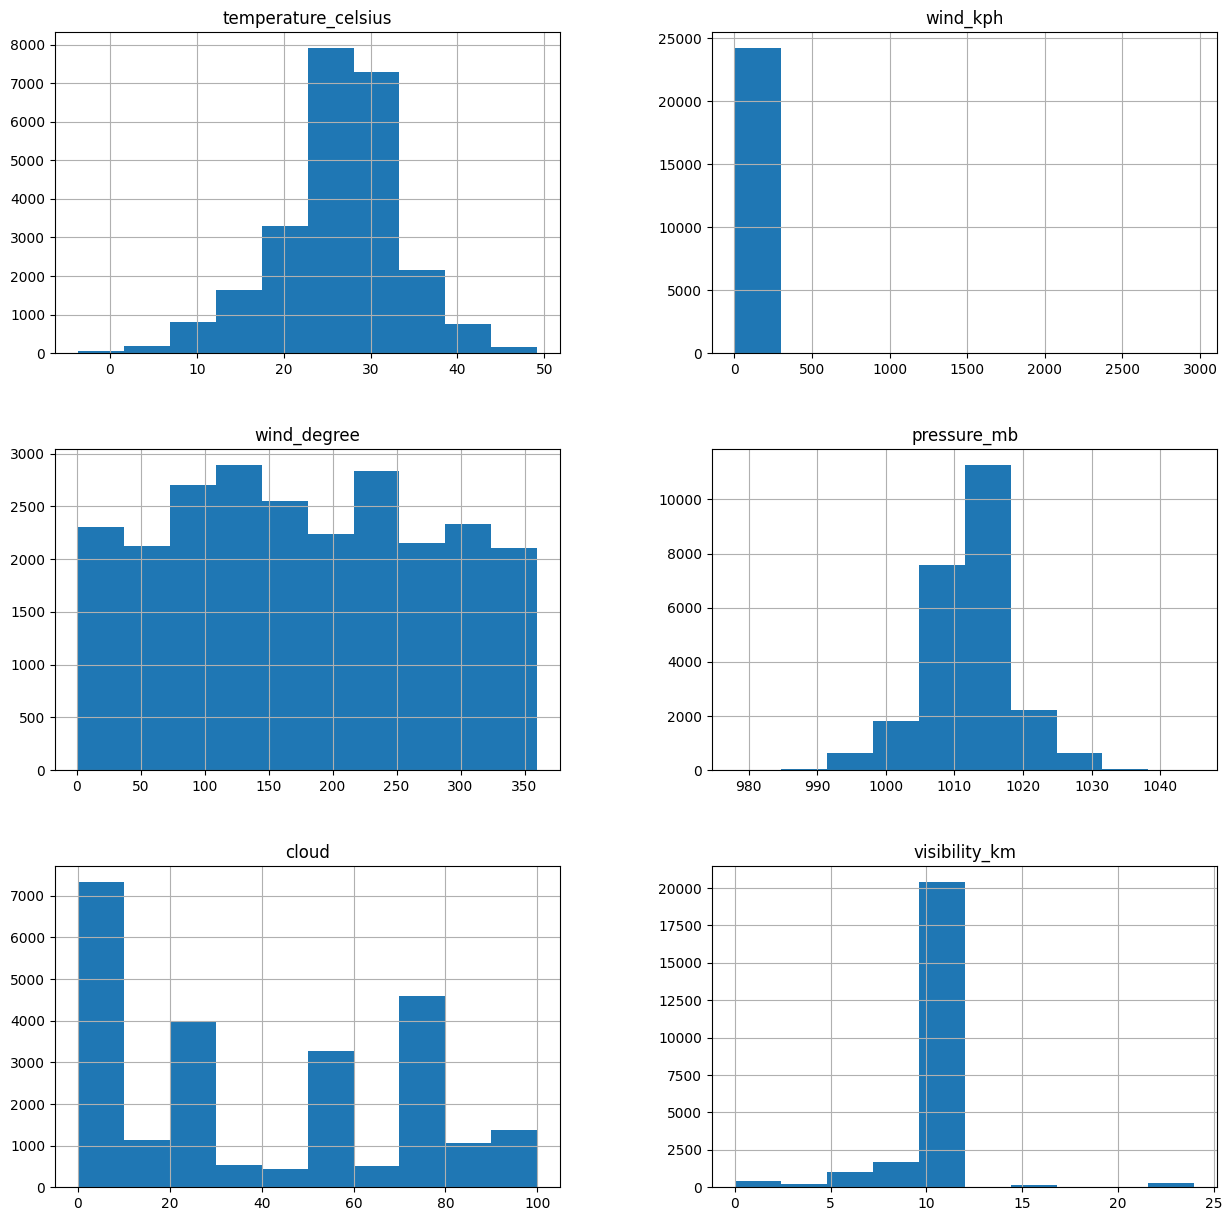

In [15]:
# plot the histogram
df.hist(bins=10,figsize=(15,15))


Plot a correlation heatmap for some numerical features

In [12]:
# find out the correlation between features
corr= df.select_dtypes("number").drop(columns=["temperature_celsius"]).corr()
corr.head()

,wind_kph,wind_degree,pressure_mb,cloud,visibility_km
wind_kph,1.000000,0.042167,-0.047601,-0.007602,0.002888
wind_degree,0.042167,1.000000,-0.133564,-0.018319,-0.086119
pressure_mb,-0.047601,-0.133564,1.000000,0.036901,0.034516
cloud,-0.007602,-0.018319,0.036901,1.000000,-0.045973
visibility_km,0.002888,-0.086119,0.034516,-0.045973,1.000000


<Axes: >

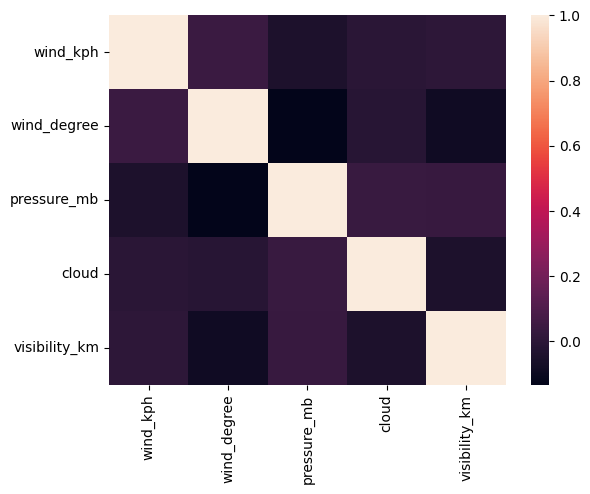

In [13]:
corr = df.select_dtypes("number").drop(columns=["temperature_celsius"]).corr()
# plot a heatmap plot
sns.heatmap(corr)

In [14]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="wind_kph",
    y="cloud",
    z="temperature_celsius",
    labels={"wind_kph":"wind_kph","cloud": "cloud","temperature_celsius": "temperature_celsius"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

# ***Split Data***

In [7]:
# define the target
target = "temperature_celsius"
y = df[target]
X = df.drop(columns=[target]) 

# split the data
cutoff = int(len(X)* 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:],y.iloc[cutoff:]


# Build Model

# Baseline


In [8]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt temperature:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt temperature: 26.38736057428181
Baseline MAE: 0.671300594795097


# Iterate

In [9]:
X_train.shape

(100, 1)

In [10]:

y_train.shape

(100,)

In [32]:
# create a pipeline 
model = make_pipeline(
   
    LinearRegression()
    
    
)
model.fit(X_train,y_train)

Pipeline(steps=[('linearregression', LinearRegression())])


# Evaluate

In [12]:
training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.42
Test MAE: 0.39


# Communicate Results

In [20]:
df_pred_test = pd.DataFrame(
{
    "y_test":y_test,
    "y_pred": model.predict(X_test),
    "diff":((model.predict(X_test)) - y_test)
}
)
df_pred_test.head()

,y_test,y_pred,diff
last_updated,,,
2024-08-25,26.561538,27.089231,0.527692
2024-08-26,26.832308,26.723077,-0.109231
2024-08-27,26.993333,27.059162,0.065829
2024-08-28,26.970769,26.863131,-0.107638
2024-08-29,26.687179,26.509231,-0.177949


In [26]:
fig = px.line(df_pred_test[["y_test","y_pred"]], labels={"value":"temperature_celsius"})
fig.show()

In [33]:
# create a pipeline 
model = make_pipeline(
    
    DecisionTreeRegressor()
    
    
)
model.fit(X_train,y_train)

Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor())])

In [18]:
training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.07
Test MAE: 0.34


In [22]:
df_pred_test = pd.DataFrame(
{
    "y_test":y_test,
    "y_pred": model.predict(X_test),
    "Diff": ((model.predict(X_test)) - y_test)
}
)
df_pred_test.head()

,y_test,y_pred,Diff
last_updated,,,
2024-08-25,26.561538,27.089231,0.527692
2024-08-26,26.832308,26.723077,-0.109231
2024-08-27,26.993333,27.059162,0.065829
2024-08-28,26.970769,26.863131,-0.107638
2024-08-29,26.687179,26.509231,-0.177949


In [27]:
fig = px.line(df_pred_test[["y_pred","y_test"]], labels={"value":"temperature_celsius"})
fig.show()

In [34]:
# create a pipeline 
model = make_pipeline(
   
    RandomForestRegressor()
    
    
)
model.fit(X_train,y_train)

Pipeline(steps=[('randomforestregressor', RandomForestRegressor())])

In [29]:
training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.22
Test MAE: 0.32


In [30]:
df_pred_test = pd.DataFrame(
{
    "y_test":y_test,
    "y_pred": model.predict(X_test),
    "Diff": ((model.predict(X_test)) - y_test)
}
)
df_pred_test.head()

,y_test,y_pred,Diff
last_updated,,,
2024-08-25,26.561538,26.915658,0.354120
2024-08-26,26.832308,26.586538,-0.245769
2024-08-27,26.993333,27.028271,0.034938
2024-08-28,26.970769,26.838662,-0.132108
2024-08-29,26.687179,26.633356,-0.053823


In [31]:
fig = px.line(df_pred_test[["y_pred","y_test"]], labels={"value":"temperature_celsius"})
fig.show()